**Using Keras and Shakespeares texts to create text**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from nltk.corpus import stopwords

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

# import os
# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)


# Load the data

In [2]:
text = open('./data/shakespeare.txt', 'r').read()

In [3]:
vocabulary = sorted(set(text))

In [4]:
len(vocabulary)

84

In [5]:
char_to_idx = {c:i for i, c in enumerate(vocabulary)}

In [6]:
idx_to_char = np.array(vocabulary)

In [7]:
encoded_text = np.array([char_to_idx[c] for c in text])

In [8]:
encoded_text[:500]

array([ 0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, 12,  0,  1,  1, 31, 73, 70, 68,  1, 61, 56, 64,
       73, 60, 74, 75,  1, 58, 73, 60, 56, 75, 76, 73, 60, 74,  1, 78, 60,
        1, 59, 60, 74, 64, 73, 60,  1, 64, 69, 58, 73, 60, 56, 74, 60,  8,
        0,  1,  1, 45, 63, 56, 75,  1, 75, 63, 60, 73, 60, 57, 80,  1, 57,
       60, 56, 76, 75, 80,  5, 74,  1, 73, 70, 74, 60,  1, 68, 64, 62, 63,
       75,  1, 69, 60, 77, 60, 73,  1, 59, 64, 60,  8,  0,  1,  1, 27, 76,
       75,  1, 56, 74,  1, 75, 63, 60,  1, 73, 64, 71, 60, 73,  1, 74, 63,
       70, 76, 67, 59,  1, 57, 80,  1, 75, 64, 68, 60,  1, 59, 60, 58, 60,
       56, 74, 60,  8,  0,  1,  1, 33, 64, 74,  1, 75, 60, 69, 59, 60, 73,
        1, 63, 60, 64, 73,  1, 68, 64, 62, 63, 75,  1, 57, 60, 56, 73,  1,
       63, 64, 74,  1, 68, 60, 68, 70, 73, 80, 21,  0,  1,  1, 27, 76, 75,
        1, 75, 63, 70, 76,  1, 58, 70, 69, 75, 73, 56, 58, 75, 60, 59,  1,
       75, 70,  1, 75, 63

In [9]:
lines_of_text = text.split('\n')
lengths_of_lines = [len(i) for i in lines_of_text if len(i)>0]

Find the length of the each line

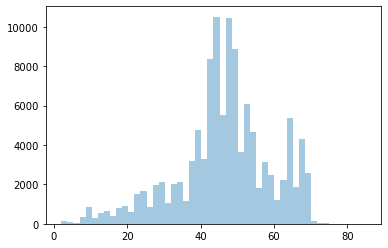

In [10]:
sns.distplot(lengths_of_lines, kde=False)
plt.show()

In [11]:
english_stopwords = stopwords.words('english')

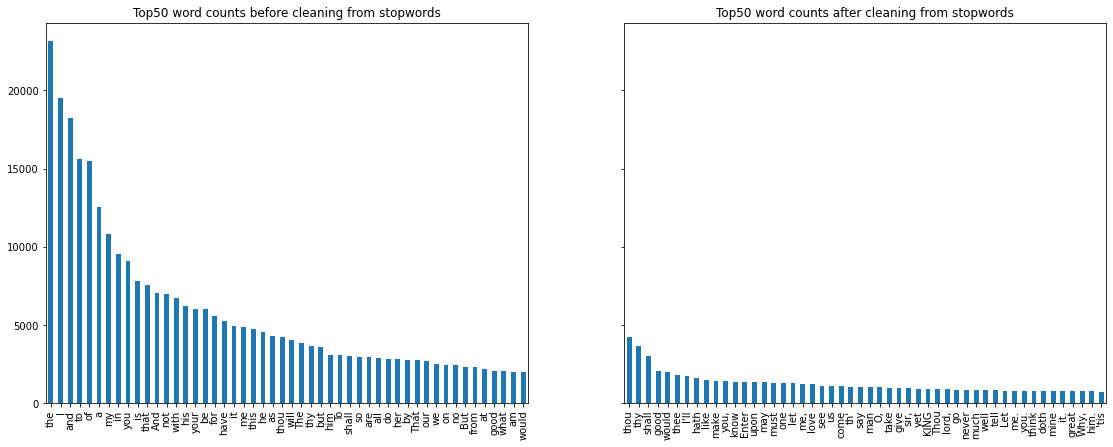

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(19, 7), sharey=True)
words = text.replace('  ', ' ').replace('\n', '').split(' ')
words = [w for w in words if w not in [' ', '', '\t']]

pd.Series(words).value_counts().head(50).plot(kind='bar', ax=ax[0])
ax[0].set_title('Top50 word counts before cleaning from stopwords')

words = [w for w in words if w.lower() not in english_stopwords]
pd.Series(words).value_counts().head(50).plot(kind='bar', ax=ax[1])
ax[1].set_title('Top50 word counts after cleaning from stopwords')
plt.show()

In [13]:
np.mean(lengths_of_lines), np.median(lengths_of_lines)

(46.365524692433695, 47.0)

In [14]:
seq_len = 120
total_num_seq = len(text) // (seq_len+1)

In [15]:
total_num_seq

45005

In [16]:
char_dataset = tf.data.Dataset.from_tensor_slices(encoded_text)

In [17]:
print(text[:100])


                     1
  From fairest creatures we desire increase,
  That thereby beauty's rose mi


In [18]:
for i in char_dataset.take(100):
    print(idx_to_char[i.numpy()], end='')


                     1
  From fairest creatures we desire increase,
  That thereby beauty's rose mi

In [19]:
sequences = char_dataset.batch(seq_len+1, drop_remainder=True)

In [20]:
def create_seq_targets(seq):
    # input_text = seq[:-1]
    # target_text = seq[1:]
    return seq[:-1], seq[1:]

In [21]:
dataset = sequences.map(create_seq_targets)

In [22]:
for input_text, target_text in dataset.take(1):
    print(input_text.numpy())
    print("".join(idx_to_char[input_text.numpy()]))
    print('---')
    print(target_text.numpy())
    print("".join(idx_to_char[target_text.numpy()]))


[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 12  0
  1  1 31 73 70 68  1 61 56 64 73 60 74 75  1 58 73 60 56 75 76 73 60 74
  1 78 60  1 59 60 74 64 73 60  1 64 69 58 73 60 56 74 60  8  0  1  1 45
 63 56 75  1 75 63 60 73 60 57 80  1 57 60 56 76 75 80  5 74  1 73 70 74
 60  1 68 64 62 63 75  1 69 60 77 60 73  1 59 64 60  8  0  1  1 27 76 75]

                     1
  From fairest creatures we desire increase,
  That thereby beauty's rose might never die,
  But
---
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 12  0  1
  1 31 73 70 68  1 61 56 64 73 60 74 75  1 58 73 60 56 75 76 73 60 74  1
 78 60  1 59 60 74 64 73 60  1 64 69 58 73 60 56 74 60  8  0  1  1 45 63
 56 75  1 75 63 60 73 60 57 80  1 57 60 56 76 75 80  5 74  1 73 70 74 60
  1 68 64 62 63 75  1 69 60 77 60 73  1 59 64 60  8  0  1  1 27 76 75  1]
                     1
  From fairest creatures we desire increase,
  That thereby beauty's rose might never die,
  But 


In [23]:
batch_size = 128

In [24]:
buffer_size = 10000
dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

In [25]:
for input_text, target_text in dataset.take(1):
    print(input_text.numpy()[0])
    print("".join(idx_to_char[input_text.numpy()[0]]))
    print('---')
    print(target_text.numpy()[0])
    print("".join(idx_to_char[target_text.numpy()[0]]))


[56 73 67 60 74 22  0  1  1  1  1 26 69 59  1 74 63 60  1 57 60 67 64 60
 77 60 74  8  1 78 63 60 73 60 77 60 73  1 75 63 60 80  1 56 73 60  1 62
 70 69 60  8  0  1  1  1  1 45 63 56 75  1 80 70 76 75 63  1 64 74  1 74
 76 73 60 67 80  1 64 69  1 75 63 60 64 73  1 58 70 68 71 56 69 80 10  0
  1  1 31 43 30 29 30 43 34 28 36 10  1 44 60 69 59  1 75 70  1 63 64 74]
arles;
    And she believes, wherever they are gone,
    That youth is surely in their company.
  FREDERICK. Send to his
---
[73 67 60 74 22  0  1  1  1  1 26 69 59  1 74 63 60  1 57 60 67 64 60 77
 60 74  8  1 78 63 60 73 60 77 60 73  1 75 63 60 80  1 56 73 60  1 62 70
 69 60  8  0  1  1  1  1 45 63 56 75  1 80 70 76 75 63  1 64 74  1 74 76
 73 60 67 80  1 64 69  1 75 63 60 64 73  1 58 70 68 71 56 69 80 10  0  1
  1 31 43 30 29 30 43 34 28 36 10  1 44 60 69 59  1 75 70  1 63 64 74  1]
rles;
    And she believes, wherever they are gone,
    That youth is surely in their company.
  FREDERICK. Send to his 


In [26]:
embed_dimensions = 64
rnn_neurons = 1026
vocabulary_size = len(vocabulary)

In [27]:
def sparse_cat_loss(y_true, y_pred):
    return sparse_categorical_crossentropy(y_true=y_true, y_pred=y_pred, from_logits=True)

In [28]:
def create_model(vocab_size, embed_dim, rnn_neurons, batch_size):

    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim,
                        batch_input_shape=[batch_size, None]))

    model.add(GRU(rnn_neurons, return_sequences=True, stateful=True,
                  recurrent_initializer='glorot_uniform'))

    model.add(Dense(vocab_size))

    model.compile(optimizer='adam', loss=sparse_cat_loss)
    return model

In [29]:
model = create_model(vocab_size=vocabulary_size,
                     embed_dim=embed_dimensions,
                     rnn_neurons=rnn_neurons,
                     batch_size=batch_size)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (128, None, 64)           5376      
_________________________________________________________________
gru (GRU)                    (128, None, 1026)         3361176   
_________________________________________________________________
dense (Dense)                (128, None, 84)           86268     
Total params: 3,452,820
Trainable params: 3,452,820
Non-trainable params: 0
_________________________________________________________________


The code below was impossible to run on my local NVidia GPU

In [30]:
# epochs = 30
# with tf.device('/device:gpu:0'):
#     model.fit(dataset, epochs=epochs)

# Create a new model to predict based on trained weights

In [31]:
model = create_model(vocab_size=vocabulary_size,
                     embed_dim=embed_dimensions,
                     rnn_neurons=rnn_neurons,
                     batch_size=1)

model.load_weights('./clfs/shakespeare_gen.h5')

model.build(tf.TensorShape([1, None]))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 64)             5376      
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1026)           3361176   
_________________________________________________________________
dense_1 (Dense)              (1, None, 84)             86268     
Total params: 3,452,820
Trainable params: 3,452,820
Non-trainable params: 0
_________________________________________________________________


In [32]:
def generate_text(model, start_seed, gen_size=500, temp=1.):

    num_to_generate = gen_size
    input_evaluation = [char_to_idx[s] for s in start_seed]
    input_evaluation = tf.expand_dims(input_evaluation, 0)
    text_generated = list()
    
    model.reset_states()
    
    for i in range(num_to_generate):
        predictions = model(input_evaluation)
        predictions = tf.squeeze(predictions, 0)
        
        predictions = predictions/temp
        
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
        input_evaluation = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx_to_char[predicted_id])
        
    return (start_seed+ "".join(text_generated))

In [34]:
print(generate_text(model, 'JULIET', gen_size=1000))

JULIETEXTy
    The acINIG. Ay, and. Come, madam, at woman. Sirrah, a spite,
    And I as great a madman to my thanks
    Shall be to quench your better. Prepare me for thee
    That liberty at your general world,
    And sigh that all the world that you shall see
    Some new access of birds but shallow,
    As brains that words age, and it hath crown'd
    To prove an infloff'red insolence.
  Edm. Here, man, a better split it, farewell.
    How soon I feed him, Banquor's Baptisto's King; Buckingham
    With groyments here is here; and part before,
    He will pursuin from your charm and bath.
  VERNON. Thou hast wishing, niece, thou damnable, a
    man to accuse
    Even in the fairest ocean; the charactore
    We have presume and horribly spies;
    Which thrown implies upon him; his rapier;
    But shall we have an arton she did spare her
    Washope the length of JOHN HORNER, ALCIBAATHE and AJAX
    Is the Warwick's match? If they hn will in body bark,
    I would have us kind of. 